## Evaluate sea ice trend tendencies

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import rotate_vector, polar_stereo, extend_grid_edges
from nemo_python_git.plots import circumpolar_plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import matplotlib.colors as cl

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

In [3]:
def make_fig_circle(ax):
    # Add circular boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Draw meridian lines with labels around circular boundary
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, xlocs=range(-180,171,30), ylocs=[], \
                      color='gray', alpha=0.5, linestyle='--', zorder=3)
    gl.xlabel_style = {'size': 8}
    # Draw concentric circles (but hide labels) for the parallels of the latitude
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, xlocs=[], ylocs=None, \
                    color='gray', alpha=0.5, linestyle='--', zorder=3)
    
    return ax

In [4]:
def subplot_map(fig, ax, ds, var='siconc', nemo_mesh=f'{base_dir}bathymetry/mesh_mask-20240305.nc', 
                vmin=None, vmax=None, cmap='viridis', quiver_color='crimson', colorbar=True):
    
    subset  = {'x':slice(0,None,18), 'y':slice(0,None,14)}
    ds_mesh = xr.open_dataset(nemo_mesh)
    tmask   = ds_mesh.tmask.isel(time_counter=0, nav_lev=0)
    
    # Limit the map to -60 degrees latitude and below:
    ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
    ax = make_fig_circle(ax)
    ax.set_facecolor('gray')
    ax.pcolormesh(ds_mesh.nav_lon, ds_mesh.nav_lat, tmask.where(tmask==1), cmap=cl.ListedColormap(['white']), transform=ccrs.PlateCarree())
    
    # Plot the data as usual
    cm = ax.pcolormesh(ds.nav_lon, ds.nav_lat, ds[var], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
    if colorbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.8, 0.17, 0.02, 0.25])
        try:
            cb = fig.colorbar(cm, cax=cbar_ax, label=ds[var].long_name, extend='both')
        except:
            cb = fig.colorbar(cm, cax=cbar_ax, label=var, extend='both')
        cb.ax.tick_params(labelsize=8)    
    
    return

In [33]:
ice_files = np.sort(glob.glob(f'{base_dir}output/ERA5_test12/files/*icemod*'))[-7:]
# ice_files = np.sort(glob.glob(f'{base_dir}output/ERA5_test12/files/*icemod*')) #[15:37]

kwagsice = {'preprocess':lambda ds: ds[['dmithd', 'dmidyn','dmiopw','dmibog','dmisni','afxthd','afxdyn','area','time_counter']], 'chunks':'auto'}
ds_ice   = xr.open_mfdataset(ice_files, **kwagsice)
# ds_ice   = ds_ice.where(ds_ice!=0)

In [6]:
def seasonal_plot(ds, variable, cmap=cmocean.cm.balance, vlim=(-5e-4, 5e-4)):
    fig, ax = plt.subplots(2,2, figsize=(8,8), subplot_kw={'projection':ccrs.SouthPolarStereo()}, dpi=150)

    season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
    season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']
    
    for a, axis in enumerate(ax.ravel()):
        ds_ice_season = ds.isel(time_counter=ds.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
        if a > 0: kwags = {'colorbar':False, 'cmap':cmap}
        else: kwags = {'colorbar':True, 'cmap':cmap}
        subplot_map(fig, axis, ds_ice_season, var=variable, vmin=vlim[0], vmax=vlim[1], **kwags)
        axis.set_title(season_names[a])
        
    return

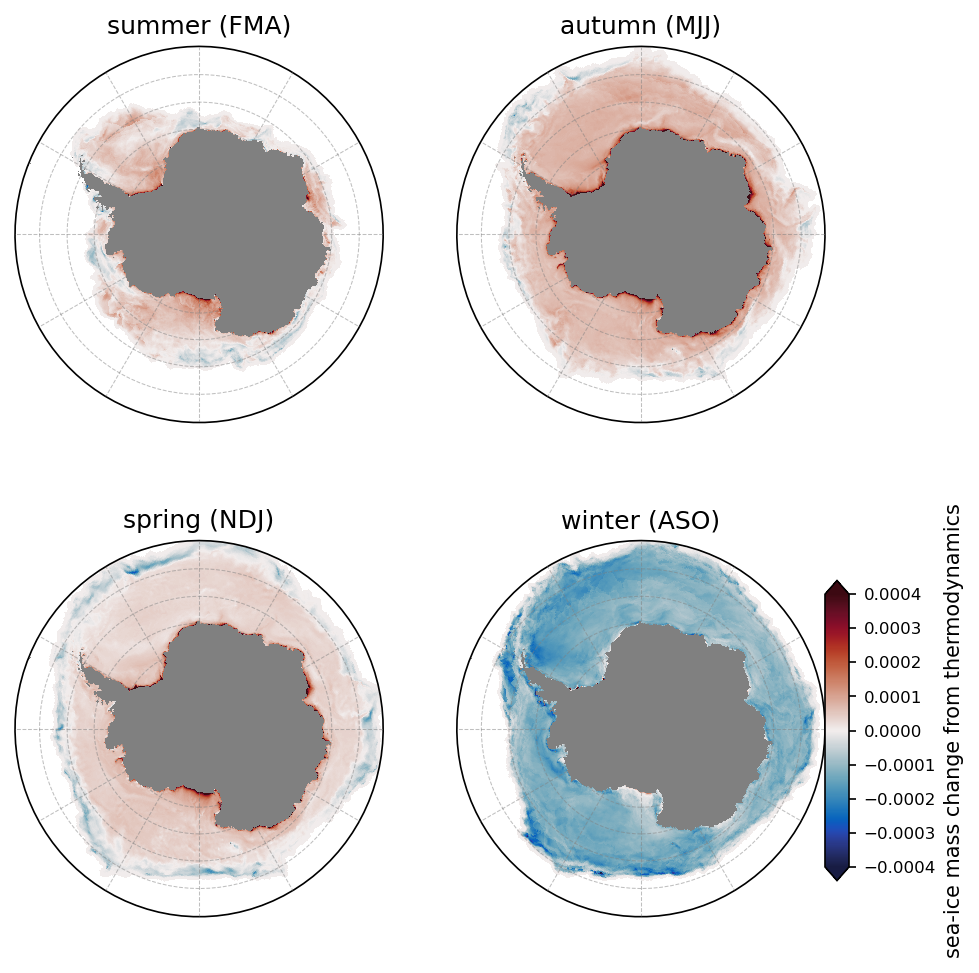

In [30]:
seasonal_plot(ds_ice, 'dmithd', vlim=(-4e-4, 4e-4))

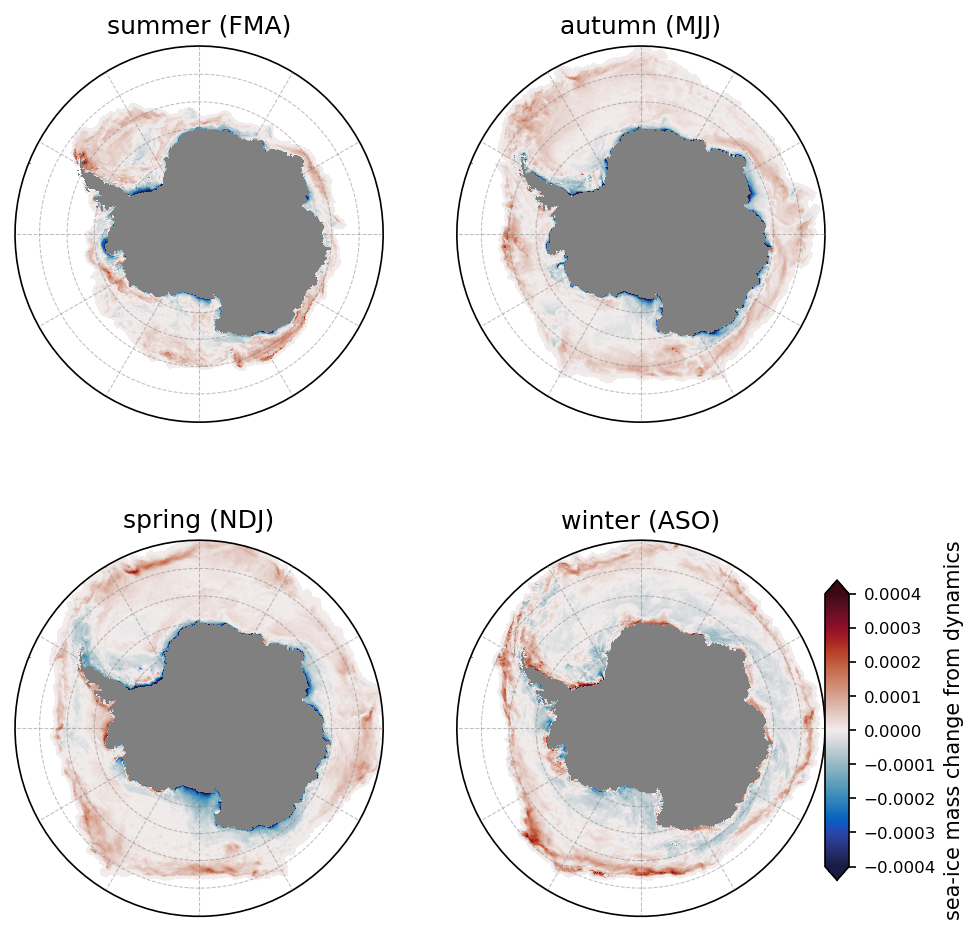

In [31]:
seasonal_plot(ds_ice, 'dmidyn', vlim=(-4e-4, 4e-4))

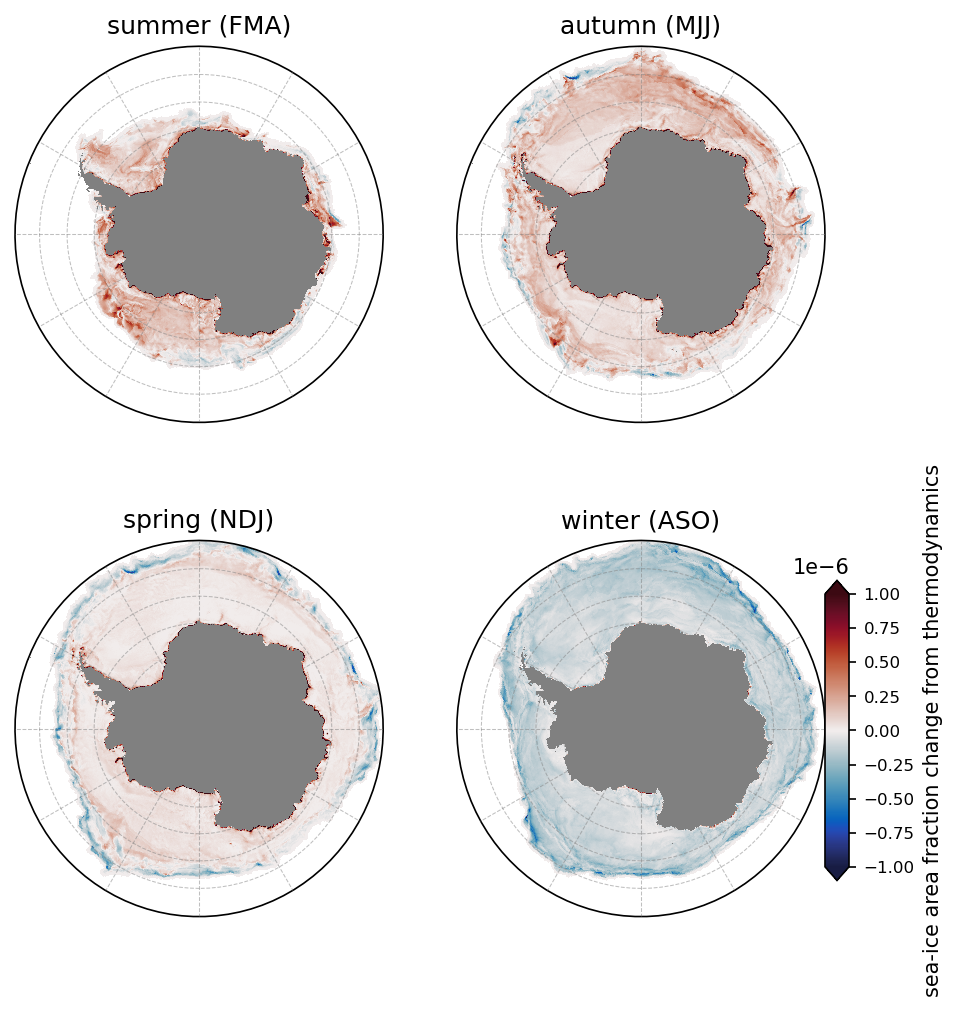

In [35]:
seasonal_plot(ds_ice, 'afxthd', vlim=(-1e-6, 1e-6))

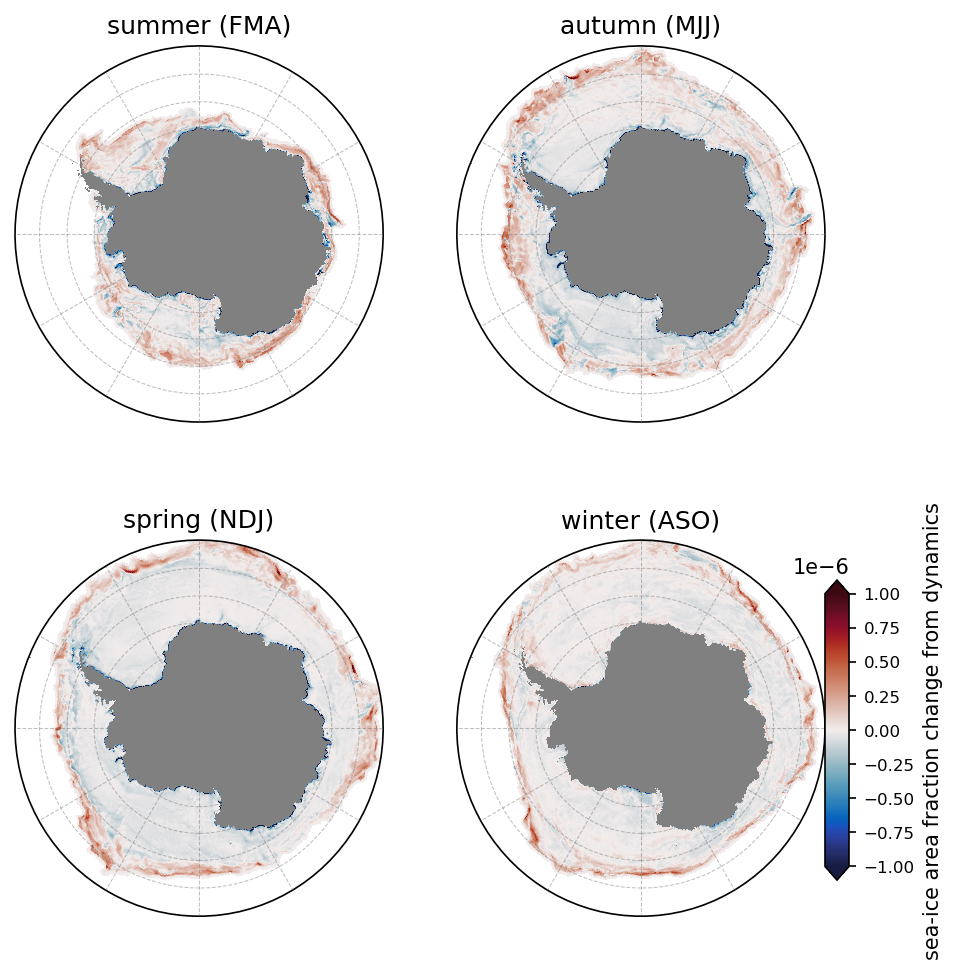

In [37]:
seasonal_plot(ds_ice, 'afxdyn',vlim=(-1e-6, 1e-6))

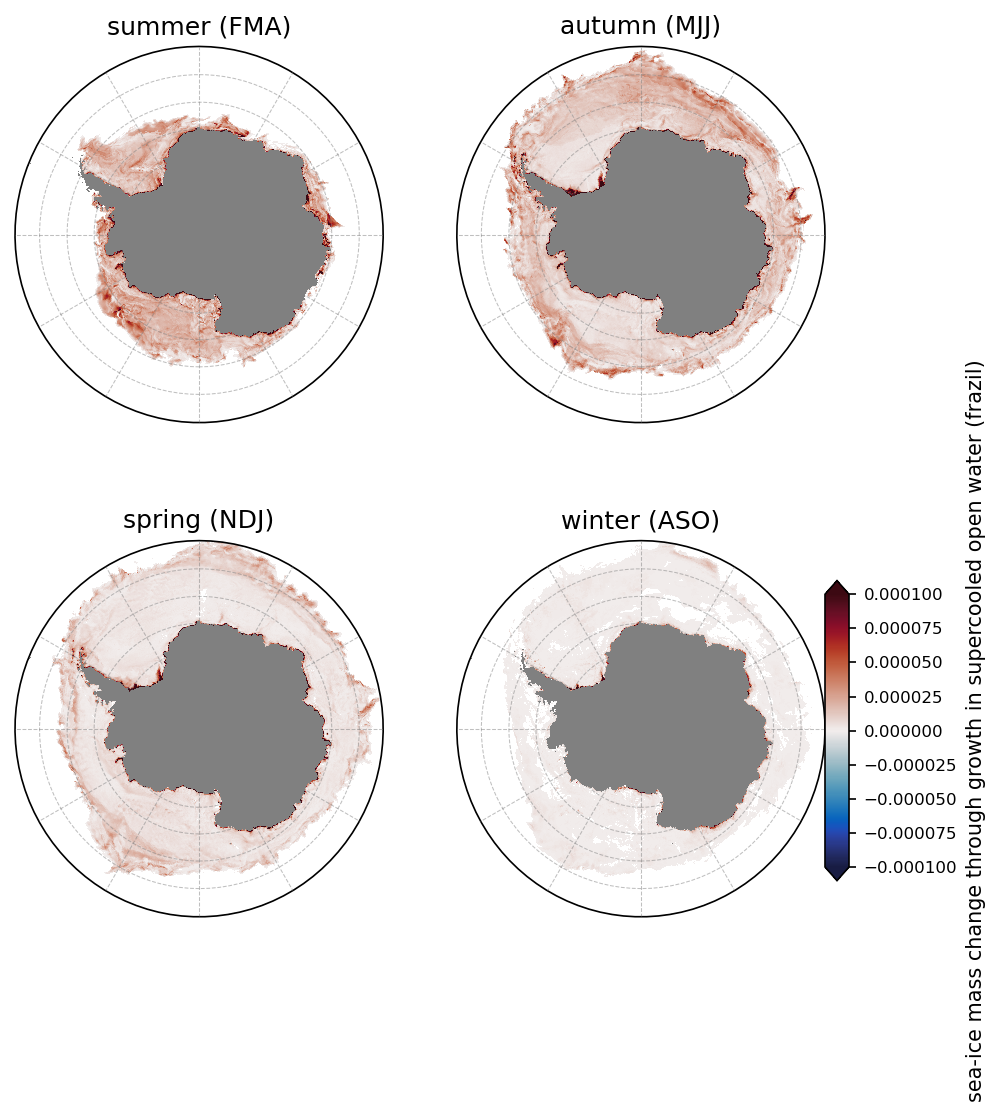

In [38]:
seasonal_plot(ds_ice, 'dmiopw', vlim=(-1e-4, 1e-4))

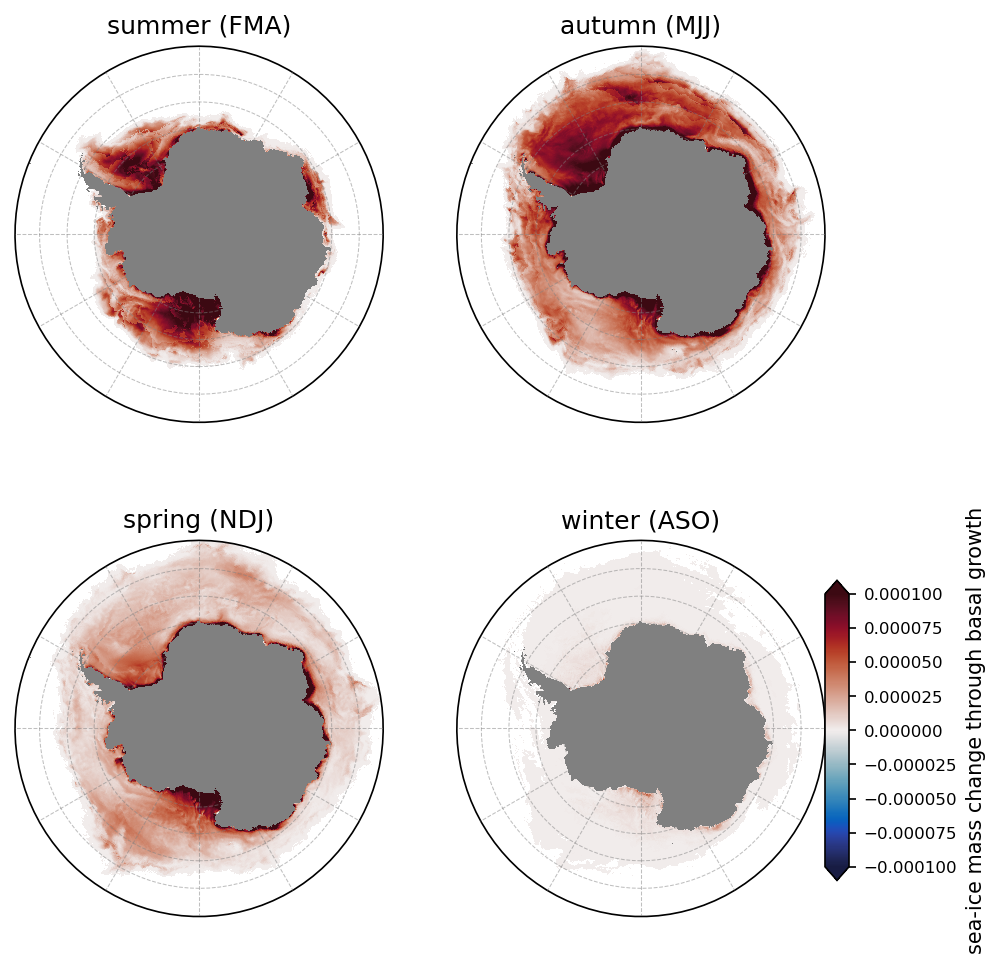

In [40]:
seasonal_plot(ds_ice, 'dmibog', vlim=(-1e-4, 1e-4))

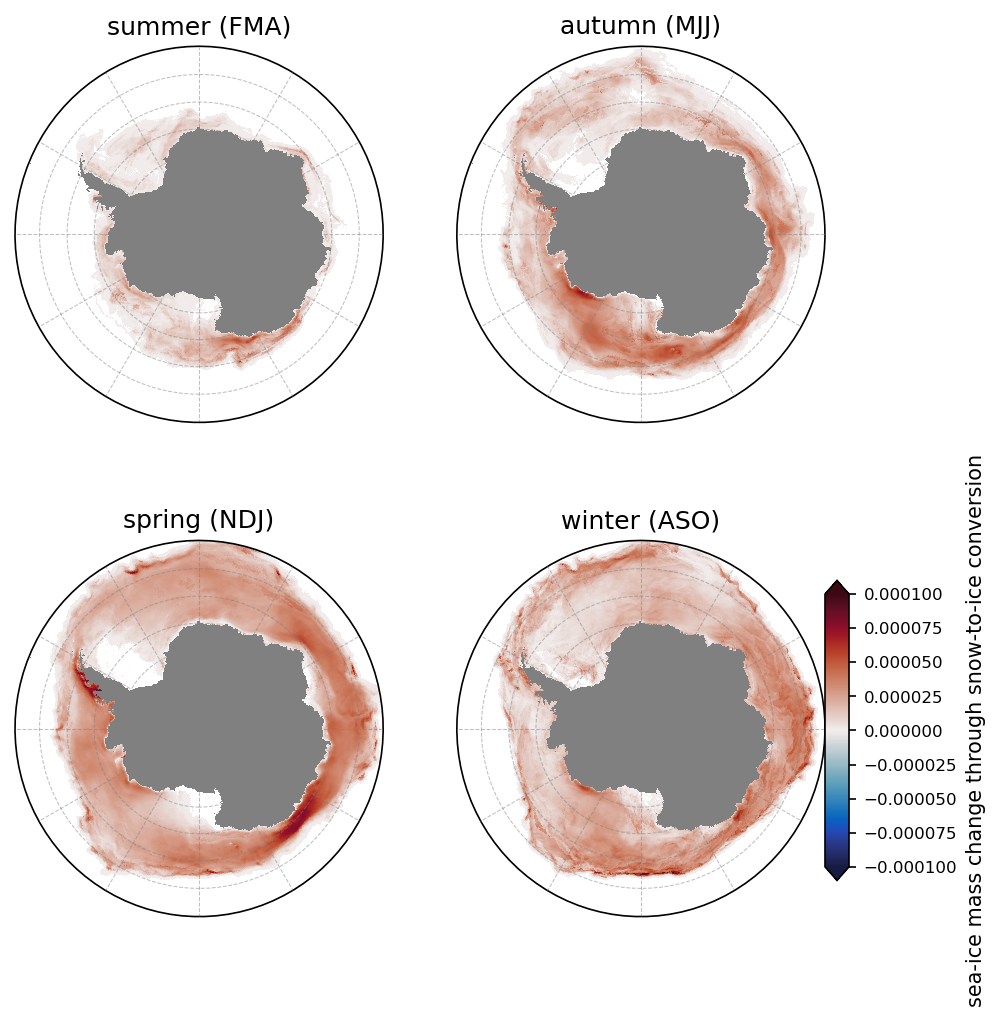

In [39]:
seasonal_plot(ds_ice, 'dmisni', vlim=(-1e-4, 1e-4))

# Sea ice production by longitude:

In [34]:
meshmask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20240305.nc')

In [38]:
ds_ice_growth = (ds_ice['dmiopw'] + ds_ice['dmibog'] + ds_ice['dmisni'])*ds_ice['area']*(3600*24*365)*(1/917)

masks = (meshmask.bathy_metry.isel(time_counter=0) < 1500)*(meshmask.nav_lat < -60)
annual_shelf_growth = ds_ice_growth.where(masks).sum(dim='y').resample({'time_counter':'YS'}).sum(dim='time_counter').mean(dim='time_counter')
annual_growth = ds_ice_growth.sum(dim='y').resample({'time_counter':'YS'}).sum(dim='time_counter').mean(dim='time_counter')

In [9]:
ds_ice = ds_ice.assign({'total_growth':ds_ice_growth*1e-9})

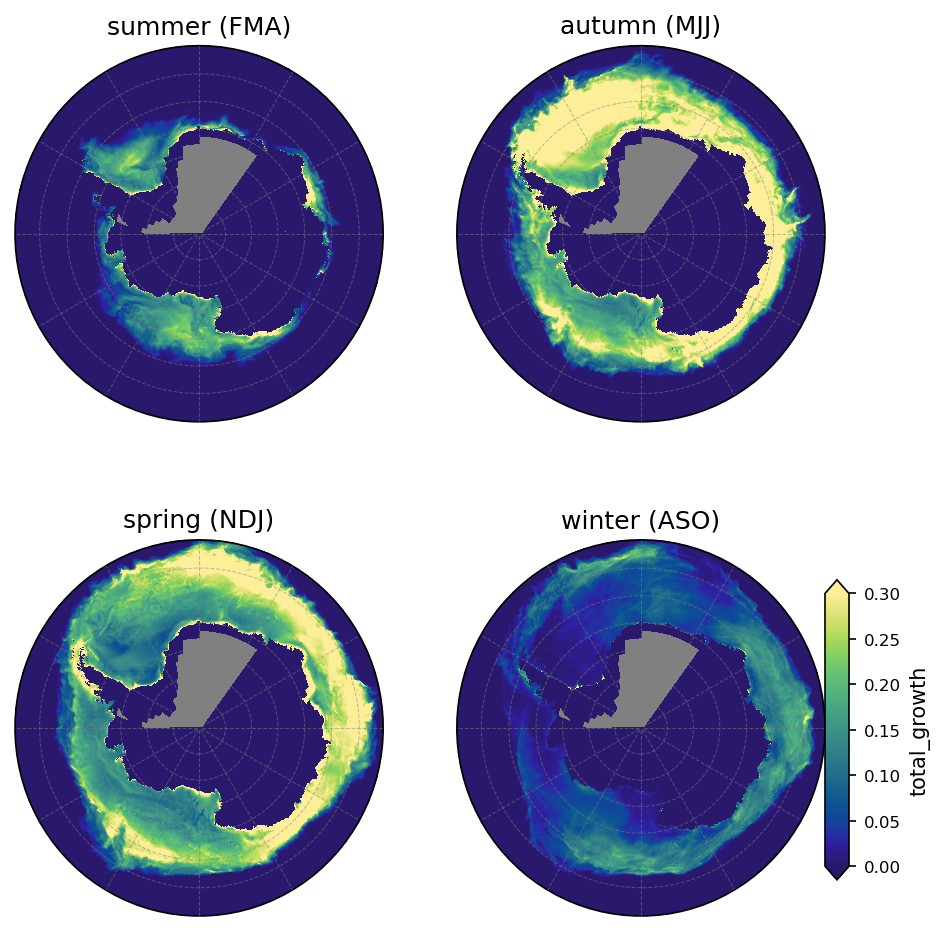

In [108]:
seasonal_plot(ds_ice, 'total_growth', vlim=(0, 0.3), cmap=cmocean.cm.haline)

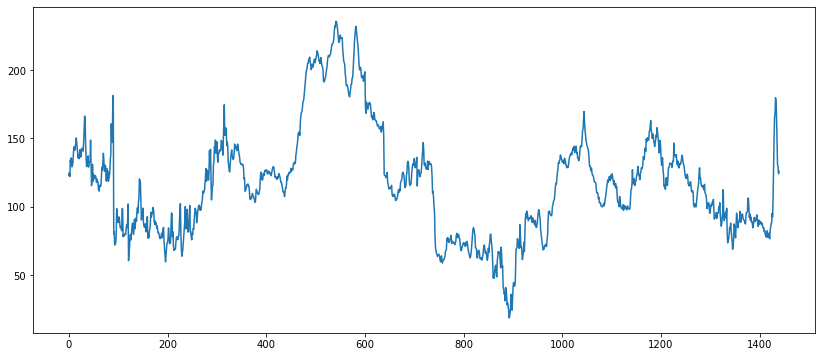

In [76]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
lons    = ds_ice_growth.x
ax.plot(lons, annual_growth*1e-9)
# ax.set_xlim(-180,180)

(-180.0, 180.0)

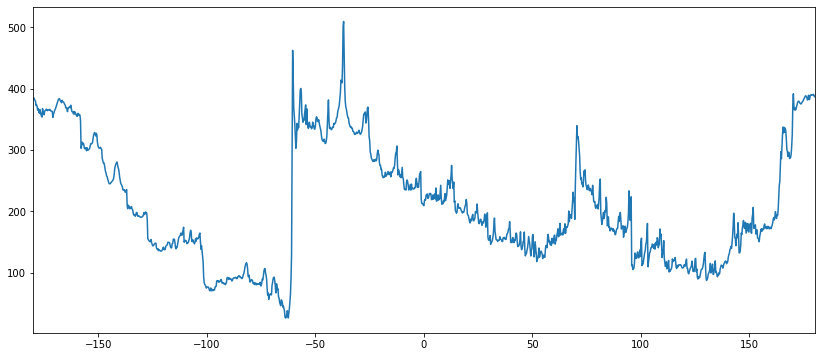

In [109]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
ind     = ds_ice_growth.nav_lon.isel(y=400).values.argsort() 
lons    = np.take_along_axis(ds_ice_growth.nav_lon.isel(y=400).values, ind, axis=0)
growths = np.take_along_axis(annual_growth.values, ind, axis=0)
ax.plot(lons, growths*1e-9)
ax.set_xlim(-180,180)

(-180.0, 180.0)

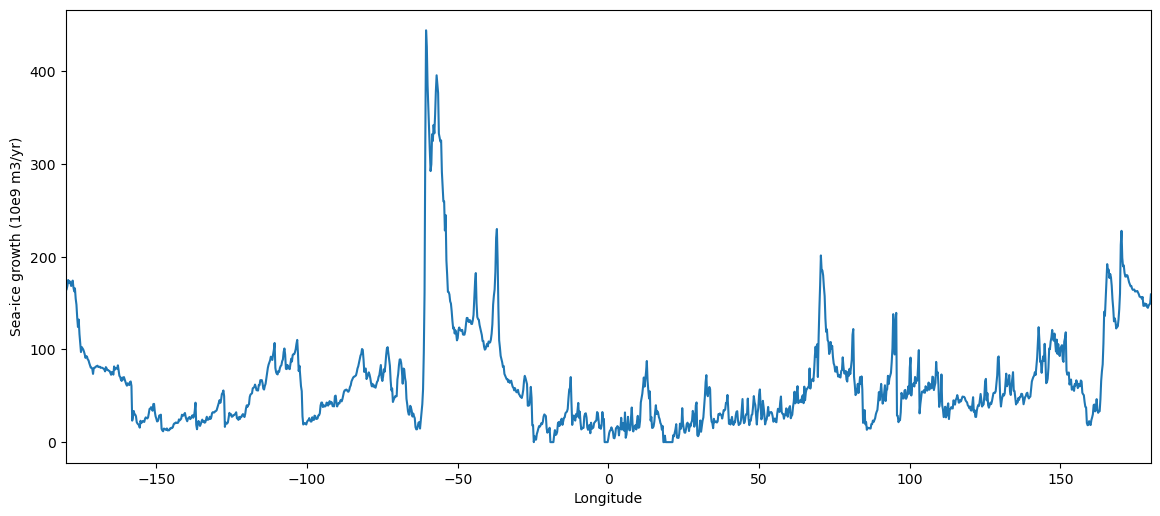

In [39]:
# repeat the same but only on the continental shelf:

fig, ax = plt.subplots(1,1, figsize=(14,6), dpi=100)
ind     = ds_ice_growth.nav_lon.isel(y=400).values.argsort() 
lons    = np.take_along_axis(ds_ice_growth.nav_lon.isel(y=400).values, ind, axis=0)
growths = np.take_along_axis(annual_shelf_growth.values, ind, axis=0)
ax.plot(lons, growths*1e-9)
ax.set_ylabel('Sea-ice growth (10e9 m3/yr)')
ax.set_xlabel('Longitude')
ax.set_xlim(-180,180)